# k-means Clustering
* By Wai Ping Jerry KWOK
* Created on 2023-09-06

#### Project Title: Categorizing Countries using k-means Clustering for HELP International
**Objective**

To categorize countries using socio-economic and health factors that determine the overall development of the country.

**Problem Statement**

HELP International has been able to raise $100 million. The CEO wants to use this money strategically and effectively and wants to fund programs in the countries that are most in need of aid. Your job is to categorize the countries using some socio-economic and health factors that determine the overall development of the country. In the end, you need to suggest how to allocate the funds among countries.

#### 1. Data

In [1]:
# import libraries for use
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import joblib
import prettytable as pt
from kneed import KneeLocator

# import sklearn for use
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

__a. Load *Country-data.csv* into a pandas dataframe. Print out the header. Use *pandas.DataFrame.describe* to summarize the data. Using markdown, explain the meaning of each column and make observations about the dataset.__

In [2]:
# load the entire csv files as DataFrame using Pandas
df = pd.read_csv('Country-data.csv', delimiter=',')

In [3]:
# print out the header
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [4]:
# summarize the data
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


There are 10 columns in the dataset.
1. country: Name of the country
2. child_mort: Death of children under 5 years of age per 1000 live births
3. exports: Exports of goods and services per capita. Given as %age of the GDP per capita
4. health: Total health spending per capita. Given as %age of GDP per capita
5. imports: Imports of goods and services per capita. Given as %age of the GDP per capita
6. income: Net income per person
7. inflation: The measurement of the annual growth rate of the Total GDP
8. life_expec: The average number of years a new born child would live if the current mortality patterns are to remain the same
9. total_fer: The number of children that would be born to each woman if the current age-fertility rates remain the same.
10. gdpp: The GDP per capita. Calculated as the Total GDP divided by the total population.

**Observations**
* After understanding the 9 features by their descriptions, we should consider all the features in the clustering model. 
* We may also divide the 9 features into two groups. 
1. Group 'Health' includes 'child_mort', 'health', 'life_expec' and 'total_fer'. In general, if a country invests more in health, it is expected to have lower child mortality, longer life expectancy and higher total fertility. 
2. Group 'Socio-economic' includes 'exports', 'imports', 'income', 'inflation' and 'gdpp'. In general, inflation, and imports and exports of goods affect GDP and in turn, affect net income per person. 
* The features such as 'income', 'gdpp' have a large range of values. We should preprocess the numerical values before we put the data into a clustering model by scaling the data with a scaler to eliminate the effect from the difference in range of different features. 

__b. Use *pandas.DataFrame.info* to check if the entries are the correct datatype, and if there are any missing values. Use *pandas.DataFrame.duplicates* to check for duplicate entries. Fix the dataset so that there are no missing values, duplicate rows, or incorrect data types. Use markdown to make observations and explain what you have done.__

In [5]:
# display the data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [6]:
df.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [7]:
df.duplicated().sum()

0

**Observations**
1. The *pandas.DataFrame.info* method prints a concise summary of the DataFrame, including the index dtype and columns, non-null values and memory usage. The column 'country' entries are object, meaning it is a string. The remaining columns are either float or int, meaning they are of numerical values. The datatypes are the same as the expectation.
2. The DataFrame.isnull() detects missing values and returns a Boolean if the values are NA. The .sum() returns the sum of values over the requested axis. Since the sum of the null value cell is 0 for all the columns, there is no missing value in the dataset.
3. The DataFrame.duplicated() returns Boolean Series denoting duplicate rows. The .sum() returns the sum of values over the requested axis. Since the sum of the duplicated cell is 0 for the dataset, there is no duplicated rows in the dataset.
4. To summarize, there is no missing value, no duplicated rows and all the columns are of expected datatypes. Therefore, it is not necessary to fix the dataset.

__Drop the 'country' column and store it in a separate dataframe. Use *seaborn.heatmap* to display the correlation matrix of the features. Use *seaborn.pairplot* to generate scatter plots and histograms. Use markdown to make observations.__

In [8]:
# drop the country column
X = df.drop(columns=['country'])
X_country = df['country']

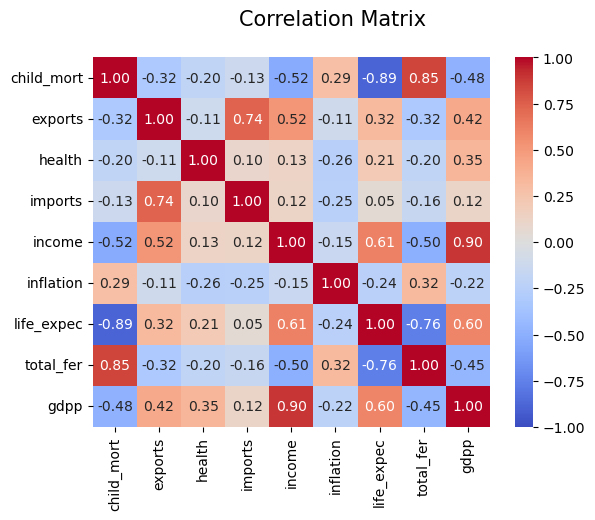

In [9]:
# display the correlation matrix using seaborn heatmap
sns.heatmap(X.corr(), cmap='coolwarm', annot=True, vmax=1, vmin=-1, fmt='.2f')

plt.suptitle('Correlation Matrix', fontsize=15)
plt.show()

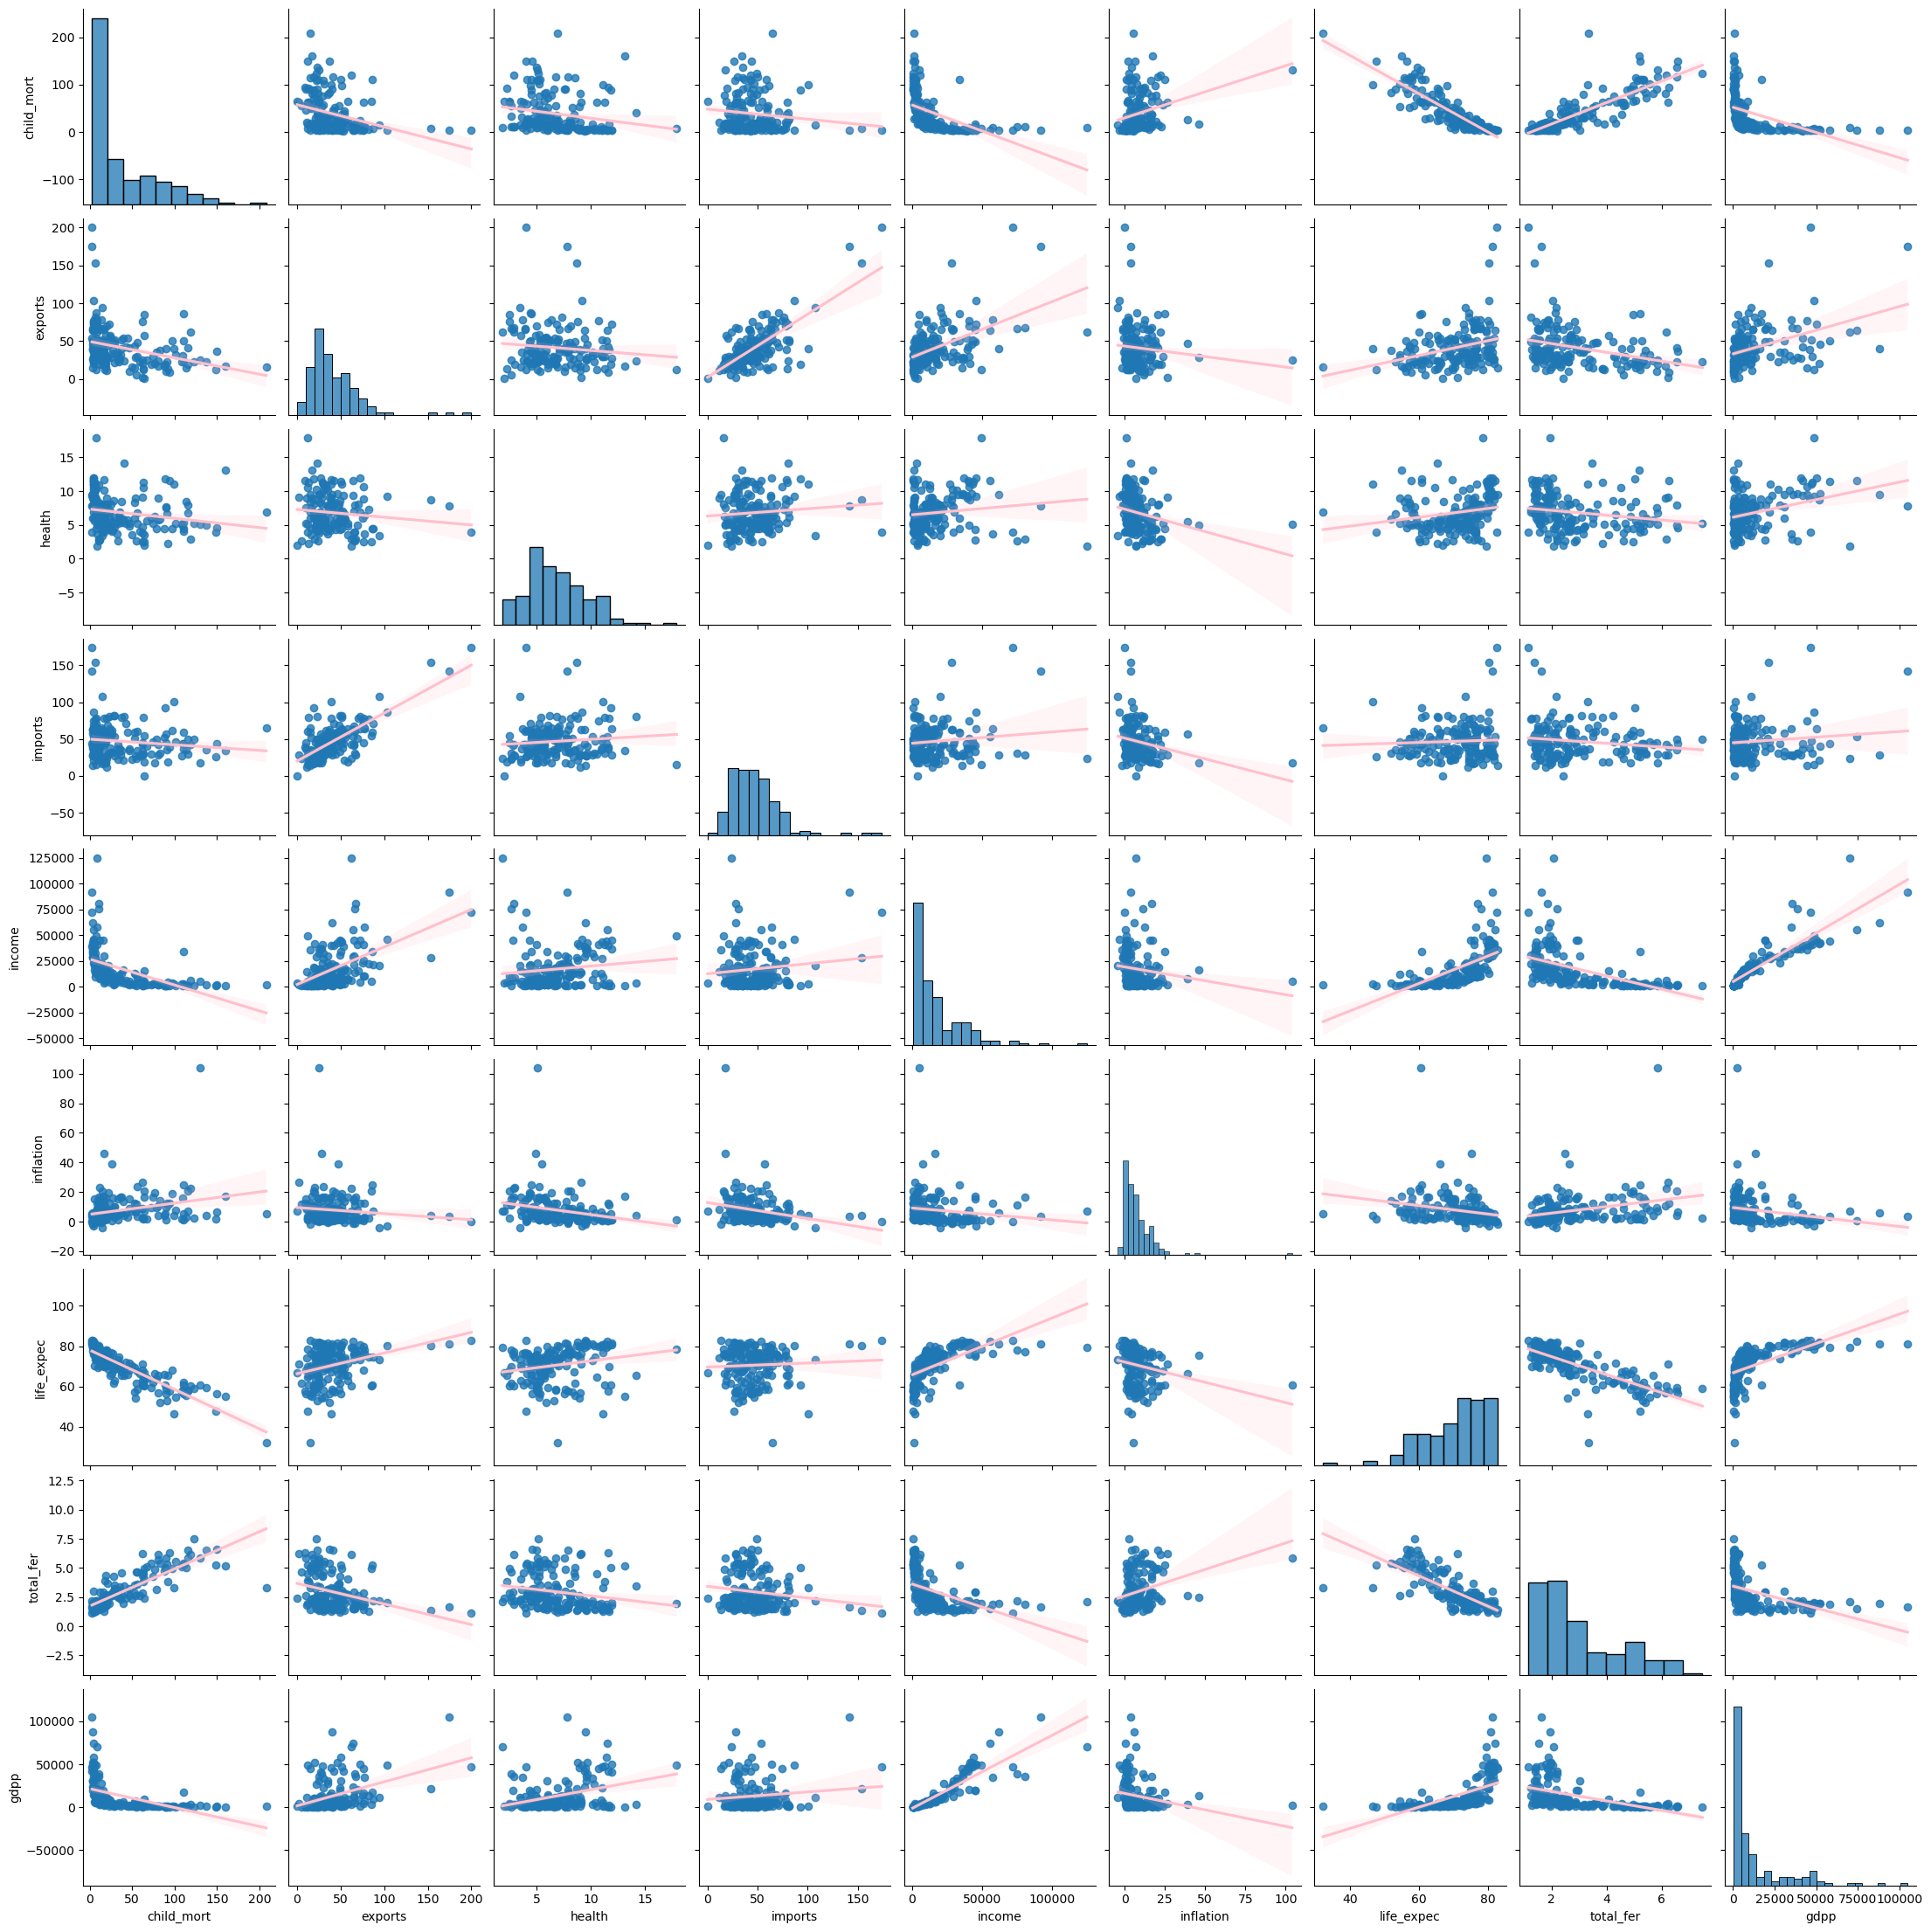

In [10]:
# display the pairplot using seaborn with a regression line
sns.pairplot(X, kind='reg', plot_kws={'line_kws':{'color':'pink'}})

**Observations**
1. Using the heatmap, it is identified that the highest correlation coefficient is between 'income' and 'gdpp' with a value of 0.9. They are both from the 'Socio-economic' Group. 
2. The second highest correlation coefficient is between 'child_mort' and 'total_fer' with a value of 0.85. They are both from the 'Health' Group. 
3. For negatively correlated features, 'life_expec' and 'child_mort' give a value of -0.89 within the 'Health' group. 
4. As from the 'Socio-economic' group, the most negatively correlated features are 'inflation' and 'imports', that give the value of -0.25.
5. The highest correlation coefficient between two features each from the two groups is 0.61 by 'income' and 'life_expec'. 
6. The pairplot helps to visualize the distribution of data. We can see that all features except 'life_expec' are skewed to the left. 'life_expec' is skewed to the right. 
7. There are some outliers when considering on 'income', 'inflation' and 'gdpp'.

#### Modeling

__Use sklearn.preprocessing.StandardScaler to scale the data. Print the header.__

In [11]:
# scale data
scaler = StandardScaler()

In [12]:
# put the scaled data to a pd DataFrame
scaled_df = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [13]:
# print the header
scaled_df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882,-0.679180
1,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973,-0.485623
2,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404,-0.465376
3,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151,-0.516268
4,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946,-0.041817


__Use sklearn.cluster.KMeans to cluster the data. Try values of n_cluster in the range [2, 10]; calculate and store the silhouette score for each.__

In [14]:
# setup the range
range_n_clusters = range(2,11)

# setup the empty list to store the silhouette scores
silhouette_scores = []

# setup the empty list to store the inertia
inertia = []    

In [15]:
# loop through the range to cluster the data and compute the silhouette scores
# sklearn.cluster.KMeans is used to cluster the data
# init='random': to initialize the centroids randomly
# n_init='auto': to run the algorithm 10 times (because init='random') with different centroid seeds and choose the best result
# random_state=100: to set the seed for the random number generator, using an int to make the output deterministic
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, init='random', n_init='auto', random_state=100)
    cluster_labels = clusterer.fit_predict(scaled_df)
    silhouette_scores.append(silhouette_score(scaled_df, cluster_labels))
    inertia.append(clusterer.inertia_)

__Create a plot of silhouette score vs. n_clusters. Using this plot, justify the number of clusters for this use case in a markdown cell. Save the corresponding model as your best model.__

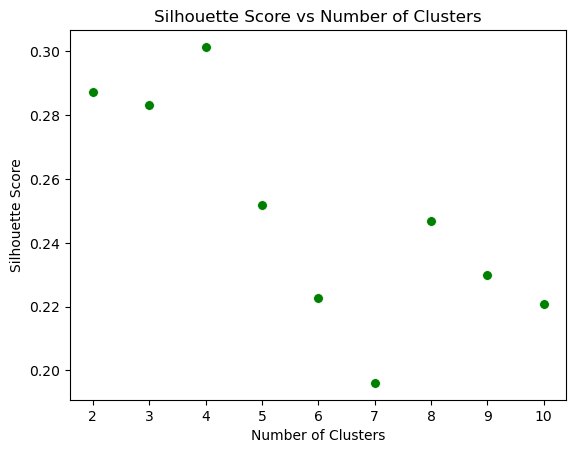

In [16]:
# plot the silhouette scores against number of clusters
sns.scatterplot(x=range_n_clusters, y=silhouette_scores, s=50, color='green')

plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.show()

From the plot, the highest silhouette score belongs to the K-means clustering that is with 4 clusters. We should also use the elbow method to help evaluate the number of clusters.

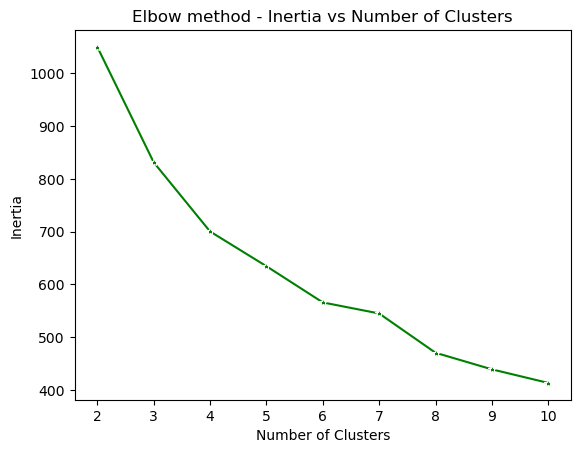

In [17]:
# plot the inertia against number of clusters
sns.lineplot(x=range_n_clusters, y=inertia, color='green', marker='*')

plt.title('Elbow method - Inertia vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

plt.show()

In [18]:
kl = KneeLocator(range_n_clusters, inertia, curve="convex", direction="decreasing")

kl.elbow

4

The elbow method also confirmed that the number of clusters should be 4. Therefore, we should pick K=4 for this project as the best model.

In [19]:
# save the best model with 4 clusters
_best = KMeans(n_clusters=4, init='random', n_init='auto', random_state=100)
_best_labels = _best.fit_predict(scaled_df)

# save the model to file
joblib.dump(_best, 'best_model.pkl')

['best_model.pkl']

#### Conclusion

__Based on your analysis in step 1, choose a pair of columns and generate a scatter plot of the data. Use the model predictions to colour the points according to the cluster they belong to. Use markdown to comment on the plot.__

To visualizse the clusters, we should pick one element from the 'health' group and one element from the 'socio-economic' group. We should use the pair 'income' and 'life_expec', which gives the highest correlation coefficient at 0.61.

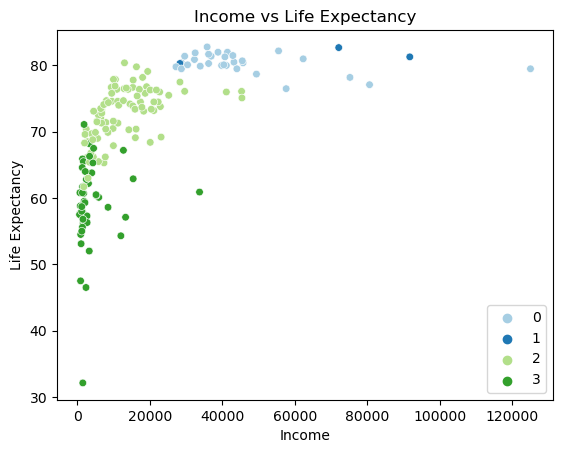

In [20]:
# visualize the clustering
sns.scatterplot(x=X['income'], y=X['life_expec'], data=X, s=30, hue=_best_labels, palette='Paired')

plt.title('Income vs Life Expectancy')
plt.xlabel('Income')
plt.ylabel('Life Expectancy')

plt.show()

**Observations**
1. From the scatter plot, it is clear to see different clusters are separated. 
2. We can see that countries of Cluster 0 and Cluster 1 have high Life Expectancy, with value greater than 75, and also high in Income, with value greater than 20000. These are characteristics of developed countries. 
3. For countries of Cluster 2, they have medium to high Life Expectancy and their income ranged from low to high. These are the characteristics of developing countries. 
4. For the countries in Cluster 3, most of them have low income, with value close to 0, and the Life Expectancy is about 50 to 70. They possess the characteristics of under-developed countries. 

We may purpose that:
* Cluster 3 is least developed countries
* Cluster 2 is developing countries
* Cluster 0 is developed countries
* Cluster 1 is well-developed countries

__Generate a histogram that shows the number of countries in each cluster. Use markdown to comment on the histogram.__

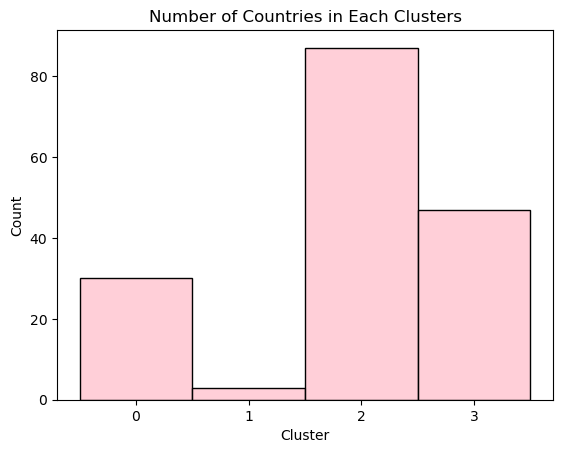

In [21]:
sns.histplot(data=_best_labels, discrete=True, bins=4, color='pink')

plt.title('Number of Countries in Each Clusters')
plt.xticks([0,1,2,3])
plt.xlabel('Cluster')

plt.show()

In [22]:
# count the number of countries in each cluster
cluster_count = pd.Series(_best_labels).value_counts()
cluster_count

2    87
3    47
0    30
1     3
Name: count, dtype: int64

**Observation**
* From the histogram, we can see that Cluster 2 has the most number of countries, with a value of 87, while Cluster 1 has the least number of countries which is only 3. 

__Print out the names of the countries within each cluster. Use markdown to comment on the countries that show up in each cluster. State the order of the clusters from those that need aid the most, to those that need aid the least.__

In [23]:
# create a new DataFrame to store the cluster labels
kmeans_df = df

In [24]:
# add the cluster labels to the DataFrame
kmeans_df['kmeans_cluster'] = _best_labels

In [25]:
# print the name of countries in each cluster
for c in range(0,4):
    table = pt.PrettyTable()
    print('Cluster', c)
    table.field_names = ['Country']
    for country in range(0, len(kmeans_df)):
        if kmeans_df['kmeans_cluster'][country] == c:
            table.add_row([kmeans_df['country'][country]])    
    print(table)

Cluster 0
+----------------------+
|       Country        |
+----------------------+
|      Australia       |
|       Austria        |
|       Belgium        |
|        Brunei        |
|        Canada        |
|        Cyprus        |
|       Denmark        |
|       Finland        |
|        France        |
|       Germany        |
|        Greece        |
|       Iceland        |
|       Ireland        |
|        Israel        |
|        Italy         |
|        Japan         |
|        Kuwait        |
|     Netherlands      |
|     New Zealand      |
|        Norway        |
|       Portugal       |
|        Qatar         |
|       Slovenia       |
|     South Korea      |
|        Spain         |
|        Sweden        |
|     Switzerland      |
| United Arab Emirates |
|    United Kingdom    |
|    United States     |
+----------------------+
Cluster 1
+------------+
|  Country   |
+------------+
| Luxembourg |
|   Malta    |
| Singapore  |
+------------+
Cluster 2
+--------------

**Observations**

By checking the name of countries in each cluster,
* Cluster 3, for example, Afghanistan, Ghana, and Lao, the countries are generally very unstable in their socio-economic environment. They are the least developed countries. They need aid the most.
* Cluster 2, for example, Cambodia, Jamaica, and Romania, the countries might sometimes be unstable in their socio-economic environment. They are the developing countries.
* Cluster 0, for example, Australia, Canada, and Switzerland, they are countries generally with stable socio-economic environment. They are the developed countries.
* Cluster 1, for example, Luxembourg, and Singapore, they are developed countries famous in stability in socio-economic environment. They are the well-developed countries. They need aid the least.

__Use markdown to describe which countries will get funds, and how much each will get.__

* Since the fund raised by HELP International is limited at $100 million and the CEO would like to fund programs in countries that are most in need of aid. The fund will be applied to the countries in least developed countries.
* To distribute the fund, we will further analyse using the sum of the standard score of 'income' and 'life_expec'. If the value is higher for both features, the country is considered to be better in both 'Health' and 'Socio-economic'.

In [26]:
# create a new DataFrame for Cluster 3
least_developed_df = kmeans_df[kmeans_df['kmeans_cluster'] == 3]

In [27]:
# reset the index
least_developed_df = least_developed_df.reset_index(drop=True)

In [28]:
least_developed_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,kmeans_cluster
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.440,56.2,5.82,553,3
1,Angola,119.0,62.3,2.85,42.9,5900,22.400,60.1,6.16,3530,3
2,Benin,111.0,23.8,4.10,37.2,1820,0.885,61.8,5.36,758,3
3,Botswana,52.5,43.6,8.30,51.3,13300,8.920,57.1,2.88,6350,3
4,Burkina Faso,116.0,19.2,6.74,29.6,1430,6.810,57.9,5.87,575,3


In [29]:
# extract the columns for use
X_least_developed = least_developed_df[['income', 'life_expec']]

In [30]:
# scale the data and put to a pd DataFrame
scaled_least_developed_df = pd.DataFrame(scaler.fit_transform(X_least_developed), columns=X_least_developed.columns)

In [31]:
scaled_least_developed_df.head()

,income,life_expec
0,-0.417885,-0.468615
1,0.350733,0.143188
2,-0.380260,0.409871
3,1.676553,-0.327430
4,-0.450135,-0.201932


In [32]:
# add the sum of scaled score to the DataFrame
scaled_least_developed_df['sum_scaled_score'] = scaled_least_developed_df['income'] + scaled_least_developed_df['life_expec']

In [33]:
scaled_least_developed_df.head()

,income,life_expec,sum_scaled_score
0,-0.417885,-0.468615,-0.886500
1,0.350733,0.143188,0.493920
2,-0.380260,0.409871,0.029611
3,1.676553,-0.327430,1.349124
4,-0.450135,-0.201932,-0.652066


In [34]:
# add back the sum scaled score to the original DataFrame
least_developed_df.loc[:, ('sum_scaled_score')] = scaled_least_developed_df.loc[:, ('sum_scaled_score')]

In [35]:
# sort the DataFrame by the sum scaled score
least_developed_df[['country', 'income', 'life_expec', 'sum_scaled_score']].sort_values(by='sum_scaled_score', ascending=True)

,country,income,life_expec,sum_scaled_score
20,Haiti,1500,32.1,-4.686835
7,Central African Republic,888,47.5,-2.380648
25,Lesotho,2380,46.5,-2.270206
28,Malawi,1030,53.1,-1.476720
31,Mozambique,918,54.5,-1.277165
46,Zambia,3280,52.0,-1.246159
38,Sierra Leone,1220,55.0,-1.144621
19,Guinea-Bissau,1390,55.6,-1.020040
0,Afghanistan,1610,56.2,-0.886500
10,"Congo, Dem. Rep.",609,57.5,-0.861910


* Within Cluster 3, we can be further divided the countries by their sum in scaled scores of 'income' and 'life_expec'. For example, Haiti has a sum scaled score of -4.68. It indicates that Haiti has a relatively low income and also a relatively short life expectancy. Under this consideration, we suggest that the fund should be distributed among those countries with negative sum scaled score only.

In [36]:
# calculate the sum of scaled score for those countries with negative sum of scaled score
neg_sum = least_developed_df['sum_scaled_score'][least_developed_df['sum_scaled_score'] < 0].sum()

In [37]:
# calculate the fund for each country
least_developed_df.loc[:,('fund')] = np.where(least_developed_df['sum_scaled_score'] < 0, least_developed_df['sum_scaled_score'] / neg_sum * 100000000, 0)

In [38]:
# display the country with the fund
least_developed_df[['country', 'fund']][least_developed_df['fund'] > 0].sort_values(by='fund', ascending=False).style.format({'fund': '{:,.0f}'})

,country,fund
20,Haiti,"18,938,329"
7,Central African Republic,"9,619,602"
25,Lesotho,"9,173,335"
28,Malawi,"5,967,058"
31,Mozambique,"5,160,706"
46,Zambia,"5,035,417"
38,Sierra Leone,"4,625,128"
19,Guinea-Bissau,"4,121,726"
0,Afghanistan,"3,582,125"
10,"Congo, Dem. Rep.","3,482,762"


* The country name and the amount of fund each will get is displayed in the above output. 